### Importing all the necessary libraries

In [323]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string
import nltk
from wordcloud import WordCloud
from textblob import Word
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Dikshant\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Reading the data and checking some random samples

In [324]:
import pandas as pd
df = pd.read_csv("amazon_alexa.tsv", sep = '\t')
df.sample(30)

rating       date                     variation  \
175        5  30-Jul-18          Heather Gray Fabric    
2269       5  30-Jul-18  Configuration: Fire TV Stick   
1131       5  29-Jul-18                   Black  Spot   
1322       5  21-Jul-18                   Black  Spot   
337        5  28-Jul-18          Heather Gray Fabric    
1211       5  28-Jul-18                   Black  Spot   
1601       2  29-Jul-18                   Black  Show   
1075       5  30-Jul-18                   White  Spot   
1667       5  28-Jul-18                   Black  Show   
672        5  22-May-18                         White   
1593       2  29-Jul-18                   Black  Show   
2576       4  30-Jul-18                    White  Dot   
243        5  29-Jul-18             Sandstone Fabric    
1158       5  29-Jul-18                   Black  Spot   
88         5  30-Jul-18             Sandstone Fabric    
2980       4  30-Jul-18                    Black  Dot   
454        5   3-Jul-18                         White   
809        5  30-Jul-18              Charcoal Fabric    
1862       5  28-Jul-18                   Black  Plus   
2615       4  30-Jul-18                    Black  Dot   
153        5  30-Jul-18              Charcoal Fabric    
289        5  29-Jul-18              Charcoal Fabric    
1086       4  30-Jul-18                   Black  Spot   
2999       5  30-Jul-18                    Black  Dot   
2829       4  30-Jul-18                    Black  Dot   
1344       5  19-Jul-18                   Black  Spot   
2672       3  30-Jul-18                    Black  Dot   
3087       5  30-Jul-18                    Black  Dot   
564        5  11-Jun-18                         Black   
318        5  29-Jul-18              Charcoal Fabric    

                                       verified_reviews  feedback  
175                                       Sound quality         1  
2269  Works great! Alexa finds all the goodies you c...         1  
1131  Great love the display and easy to use, though...         1  
1322  I got this on Prime day and figured I'd see wh...         1  
337   I like the volume up and down on the top so I ...         1  
1211                                         no problem         1  
1601  Disappointed that this device Is not able to a...         0  
1075                   I love it.  It is so easy to use         1  
1667  I love being able to see information that Alex...         1  
672   Bought this to go in my niece's room. You can'...         1  
1593  Echo Show is said to work with certain apps bu...         0  
2576                                   Work pretty well         1  
243   I received the echo in perfect condition. The ...         1  
1158                 Is great. Use it for music mostly.         1  
88    The echo works well. I was able to sync it wit...         1  
2980                    Gave as a gift - they loved it.         1  
454               The simplicity of use and setting up.         1  
809   Still learning all the ways to use it.  It is ...         1  
1862  Love it, very easy to set up.love that you can...         1  
2615  Easy to set up. Still trying to get it to conn...         1  
153   We were pleasantly surprised at the sound qual...         1  
289   I replaced my 1st gen, was concerned about a s...         1  
1086  I was skeptical at first but &#34;it&#34; grow...         1  
2999  Echo Dot and related devices are the best thin...         1  
2829  I bought the echo dot while it was on sale for...         1  
1344  I highly recommend the spot! I have it connect...         1  
2672  Got this for my 2nd Echo in the house, I alrea...         1  
3087                                            Love it         1  
564   I bought it because everyone was saying how mu...         1  
318   My  wife & I enjoy the ease of playing our mus...         1

Checking the distribution across different product variation

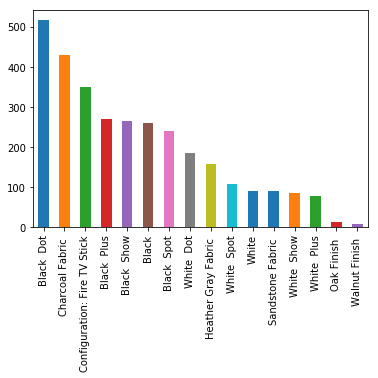

In [325]:
df['variation'].value_counts().plot(kind='bar')

# Comparing ratings for different product categories

In [326]:
for variation in df['variation'].unique():
    ind = (df['variation']==variation)
    if variation in ['Charcoal Fabric ','Heather Gray Fabric ','Sandstone Fabric ']:
        df.loc[ind,'category']= 'Echo Fabric'
    if variation in ['Walnut Finish ','Oak Finish ']:
        df.loc[ind,'category']= 'Echo Finish'
    if variation in ['Black  Spot','White  Spot']:
        df.loc[ind,'category']= 'Echo Spot'
    if variation in ['Black  Show','White  Show']:
        df.loc[ind,'category']= 'Echo Show'
    if variation in ['Black  Plus','White  Plus']:
        df.loc[ind,'category']= 'Echo Plus'
    if variation in ['Black  Dot','White  Dot']:
        df.loc[ind,'category']= 'Echo Dot'
    if variation in ['Configuration: Fire TV Stick']:
        df.loc[ind,'category']= 'Fire Stick'
    if variation in ['Black','White']:
        df.loc[ind,'category']= 'Echo'

In [327]:
pd.pivot_table(df, values='rating', index=['category'],aggfunc = np.mean)

rating
category             
Echo         4.210227
Echo Dot     4.445714
Echo Fabric  4.672083
Echo Finish  4.869565
Echo Plus    4.367816
Echo Show    4.440000
Echo Spot    4.311429
Fire Stick   4.591429

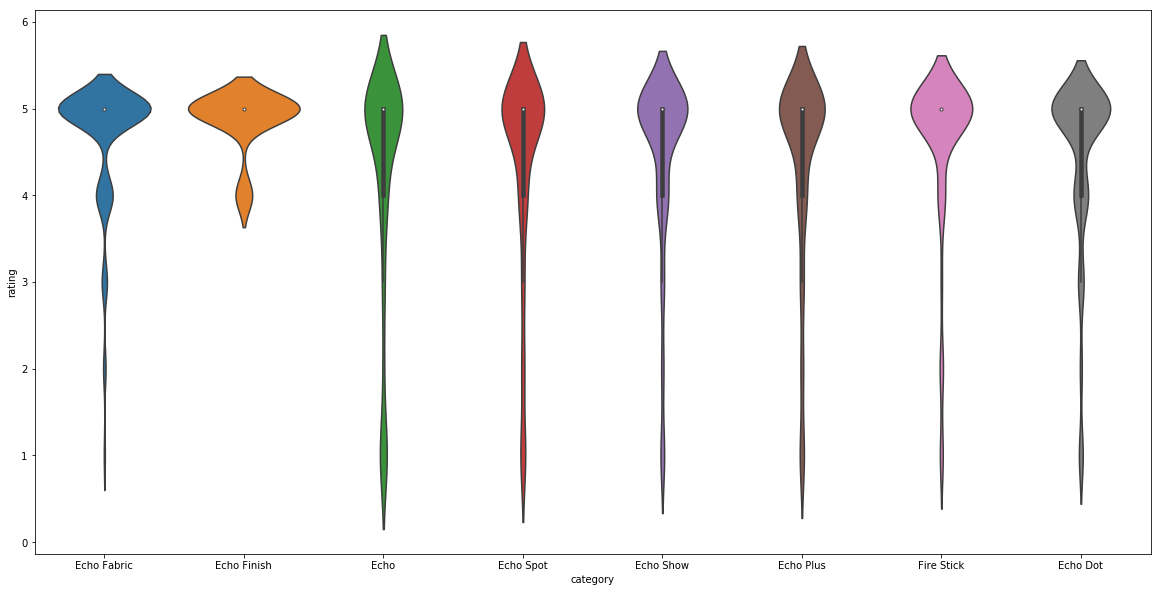

In [328]:
plt.figure(figsize=(20,10))
sns.violinplot(x='category', y='rating', data=df)

# Comparing average ratings for same product categories for different colours

In [329]:
pd.pivot_table(df, values='rating', index=['category','variation'],aggfunc = np.mean)

rating
category    variation                             
Echo        Black                         4.233716
            White                         4.142857
Echo Dot    Black  Dot                    4.453488
            White  Dot                    4.423913
Echo Fabric Charcoal Fabric               4.730233
            Heather Gray Fabric           4.694268
            Sandstone Fabric              4.355556
Echo Finish Oak Finish                    4.857143
            Walnut Finish                 4.888889
Echo Plus   Black  Plus                   4.370370
            White  Plus                   4.358974
Echo Show   Black  Show                   4.490566
            White  Show                   4.282353
Echo Spot   Black  Spot                   4.311203
            White  Spot                   4.311927
Fire Stick  Configuration: Fire TV Stick  4.591429

# Sentiment Analysis of reviews

Doing some initial text-preprocessing before doing sentiment analysis. First, we drop reviews with no text.

In [330]:
df['verified_reviews'] = df['verified_reviews'].apply(lambda x: x if len(x.split())>0 else np.nan)

In [331]:
#checking null/missing values
df.isnull().sum()

rating               0
date                 0
variation            0
verified_reviews    79
feedback             0
category             0
dtype: int64

In [332]:
df = df.dropna()
df = df.reindex()

In [333]:
#creating a general string substitite function
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 

In [334]:
# remove special characters, numbers, punctuations
df['tidy_verified_reviews'] = df['verified_reviews'].str.replace("[^a-z'A-Z]", " ")

#lower-casing everything
df['tidy_verified_reviews'] = df['tidy_verified_reviews'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#removing stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
#df['tidy_verified_reviews'] = df['tidy_verified_reviews'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

#Lemmatizing
df['tidy_verified_reviews'] = df['tidy_verified_reviews'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [335]:
df.loc[:,['verified_reviews','tidy_verified_reviews']].sample(30)

verified_reviews  \
879   My mom bought a few Echo Dots and repeated ask...   
2925  Love Alexa. Love the Echo Dot but we have trou...   
2275                                          Excellent   
196                                          I love it!   
1408  Alexa is fun! I’ve added smart home aspects, m...   
1775  I don'r know how to use it yet.  Need more exp...   
2625  I'm finding more and more uses for this all th...   
593                                 Absolutly love it !   
2893                                This is pretty cool   
1946  Nothing to dislike I love my new toy that has ...   
1769                          Using as a hub and music.   
2460                                              Great   
1455  Great item for knowledge, directions, music,la...   
298   It's extremely useful in simple things like sp...   
1069                                 Love my Echo Spot!   
1406                                          Very good   
1667  I love being able to see information that Alex...   
1146  I love it.  I made a group with my echo dot so...   
881                      Easy set up very user friendly   
1431  I’m really enjoying this product. Love the fla...   
111   Sound is terrible if u want good music too get...   
2043  Alexa is great only she will laugh or add rand...   
532   Works very well, but the microphone don&#34;t ...   
2387  Easy to set up, lots of things to watch and pr...   
2090  I am the Training Coordinator at my company an...   
1955                                           Awesome!   
1481  So far so good.  Neat to have a visual version...   
1488              Highly like my eco show.no complaints   
309   Still getting used to Alexa, don't have her co...   
1982  Works great I bought this Direct from amazon, ...   

                                  tidy_verified_reviews  
879   my mom bought a few echo dot and repeated ask ...  
2925  love alexa love the echo dot but we have troub...  
2275                                          excellent  
196                                           i love it  
1408  alexa is fun i ve added smart home aspect my f...  
1775  i don'r know how to use it yet need more expli...  
2625  i'm finding more and more us for this all the ...  
593                                   absolutly love it  
2893                                this is pretty cool  
1946  nothing to dislike i love my new toy that ha m...  
1769                            using a a hub and music  
2460                                              great  
1455  great item for knowledge direction music laugh...  
298   it's extremely useful in simple thing like spo...  
1069                                  love my echo spot  
1406                                          very good  
1667  i love being able to see information that alex...  
1146  i love it i made a group with my echo dot so i...  
881                      easy set up very user friendly  
1431  i m really enjoying this product love the flas...  
111   sound is terrible if u want good music too get...  
2043  alexa is great only she will laugh or add rand...  
532   work very well but the microphone don t pick u...  
2387  easy to set up lot of thing to watch and progr...  
2090  i am the training coordinator at my company an...  
1955                                            awesome  
1481  so far so good neat to have a visual version o...  
1488               highly like my eco show no complaint  
309   still getting used to alexa don't have her con...  
1982  work great i bought this direct from amazon an...

In [336]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def analyze_sentiment(df):
    sentiments = []
    sid = SentimentIntensityAnalyzer()
    for i in range(df.shape[0]):
        #if i % 100 == 0:
            #print(i)
        line = df['tidy_verified_reviews'].iloc[i]
        sentiment = sid.polarity_scores(line)
        sentiments.append([sentiment['neg'], sentiment['pos'],
                           sentiment['neu'], sentiment['compound']])
    df[['neg', 'pos', 'neu', 'compound']] = pd.DataFrame(sentiments)
    df['Negative'] = df['compound'] < -0.1
    df['Positive'] = df['compound'] > 0.1
    return df


In [342]:
df_final = analyze_sentiment(df)
df_final[df_final.Negative == 1].sample(30)
#df_final.sample(30)

rating       date                     variation  \
171        5  30-Jul-18          Heather Gray Fabric    
2533       3  30-Jul-18                    Black  Dot   
2839       4  30-Jul-18                    Black  Dot   
543        5  16-Jun-18                         Black   
3049       5  30-Jul-18                    Black  Dot   
1649       4  29-Jul-18                   Black  Show   
2791       4  30-Jul-18                    White  Dot   
1949       5  26-Jul-18                   Black  Plus   
2407       5  30-Jul-18  Configuration: Fire TV Stick   
1200       2  28-Jul-18                   Black  Spot   
1743       5  28-Jul-18                   Black  Show   
2067       5   7-Jul-18                   White  Plus   
2916       5  30-Jul-18                    Black  Dot   
1237       5  26-Jul-18                   Black  Spot   
1359       5  19-Jul-18                   White  Spot   
2437       4  30-Jul-18  Configuration: Fire TV Stick   
1861       5  28-Jul-18                   White  Plus   
653        1  26-May-18                         White   
984        5  29-Jul-18              Charcoal Fabric    
1378       2  17-Jul-18                   Black  Spot   
796        5  30-Jul-18          Heather Gray Fabric    
1894       1  27-Jul-18                   Black  Plus   
935        4  29-Jul-18             Sandstone Fabric    
1852       5  28-Jul-18                   Black  Plus   
1262       5  25-Jul-18                   White  Spot   
507        5  23-Jun-18                         Black   
2554       5  30-Jul-18                    Black  Dot   
1164       4  29-Jul-18                   White  Spot   
2460       5  30-Jul-18                    Black  Dot   
2892       1  30-Jul-18                    Black  Dot   

                                       verified_reviews  feedback  \
171       Super easy set up and am loving our new Echo!         1   
2533  I bought this for my healing room.  I play con...         1   
2839  I had some trouble with my echo dot when I fir...         1   
543   This is just like new -- same performance as o...         1   
3049  I had put this off for awhile but finally got ...         1   
1649  Works with Blink video cameras.  Does not work...         1   
2791  My three year old loves it.  Good for doing ba...         1   
1949        Arrived right on time and works as expected         1   
2407             I am very pleased with the Fire Stick.         1   
1200                                                Meh         0   
1743                           Bought this on Prime day         1   
2067  So far using it for lights and music. Will con...         1   
2916                   Love it... can't stop using it..         1   
1237  I am a small business owner with no staff. Wit...         1   
1359  Very nicely constructed. My wife wanted a seco...         1   
2437                                 Good wifi TV stick         1   
1861    Easy to set up and works like it's supposed to.         1   
653   I wanted a white dot for my white bathroom.  T...         0   
984   I replaced my 1st gen, was concerned about a s...         1   
1378                                    Fairly useless.         0   
796                                            Love it!         1   
1894  no it is broke and I can't get help fixing or ...         0   
935                                  Like it to do more         1   
1852  The sound is wonderful and it just plain works...         1   
1262  Bought this for our son as his birthday presen...         1   
507   Have these in almost every room. I really have...         1   
2554  Purchased this for a discount on Prime Day to ...         1   
1164                                     so far just ok         1   
2460                                              Great         1   
2892                             Cheap and cheap sound.         0   

         category                              tidy_verified_reviews    neg  \
171   Echo Fabric  

# Creating a wordcloud of reviews- all, good and bad

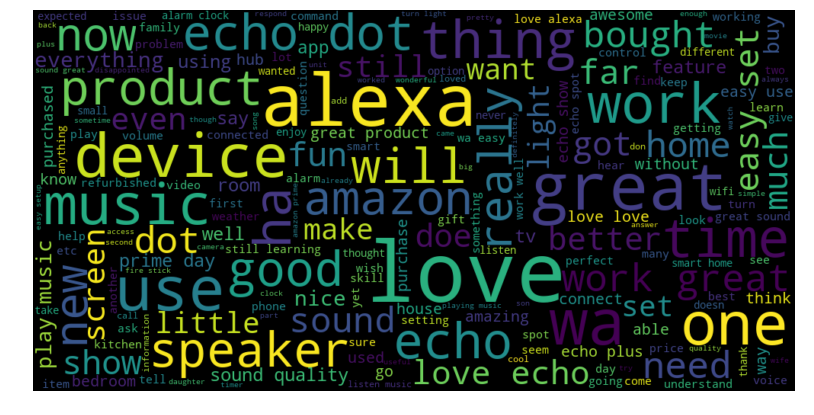

In [338]:
all_words = ' '.join([text for text in df_final['tidy_verified_reviews']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=1000, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

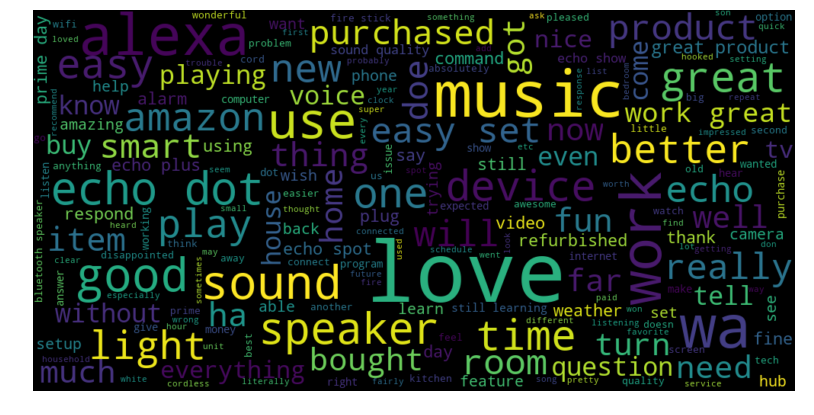

In [346]:
negative_words = ' '.join([text for text in df_final['tidy_verified_reviews'][df_final['Negative'] == 1]])
wordcloud = WordCloud(width=1000, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

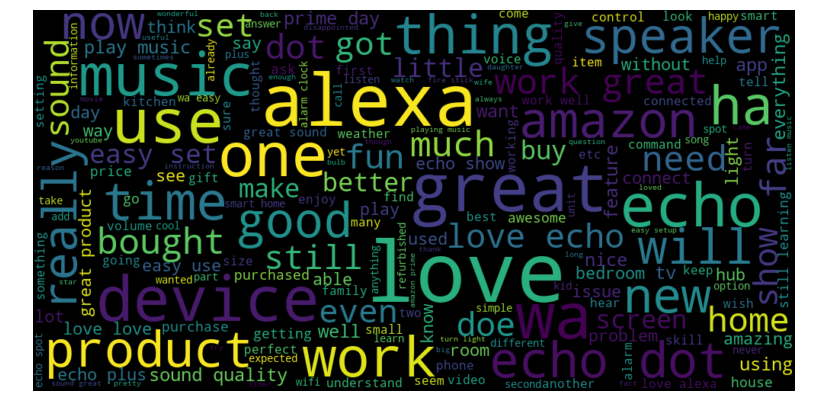

In [347]:
normal_words =' '.join([text for text in df_final['tidy_verified_reviews'][df_final['Positive'] == 1]])

wordcloud = WordCloud(width=1000, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Trend in purchase, ratings, sentiments with time